In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

In [3]:
df=pd.read_csv(r"C:\Users\User\Desktop\python projekty\data analitics\car_prices.csv")
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [4]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

<Axes: >

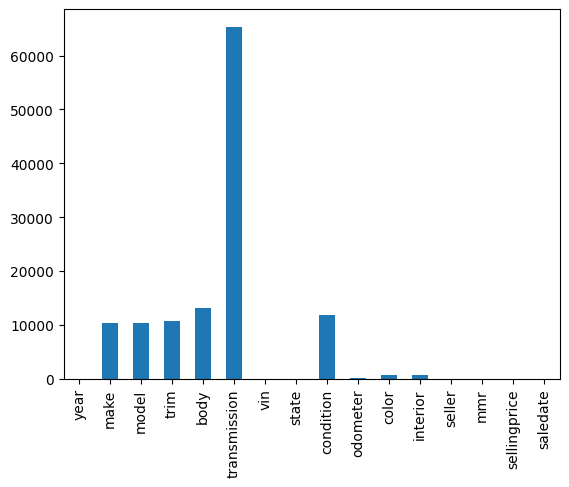

In [5]:

df.isnull().sum().plot(kind='bar')

In [6]:
null_count=df.isnull().sum()
percentage_null=df.isnull().mean()
missing_df = pd.DataFrame({
    "null_count":null_count,
    "null_%":percentage_null*100
})
missing_df

,null_count,null_%
year,0,0.000000
make,10301,1.843292
model,10399,1.860829
trim,10651,1.905922
body,13195,2.361154
transmission,65352,11.694287
vin,4,0.000716
state,0,0.000000
condition,11820,2.115107
odometer,94,0.016821


### Missing data strategy
- **<1% missing:** drop affected rows (negligible impact).
- **1–10% missing:** check whether missingness looks random before choosing treatment.
- **`transmission` (~11.7%):** investigate in depth first — key price driver, missingness may be systematic.

In [7]:
df.isnull().mean().sort_values(ascending=False)*100

transmission    11.694287
body             2.361154
condition        2.115107
trim             1.905922
model            1.860829
make             1.843292
color            0.134028
interior         0.134028
odometer         0.016821
mmr              0.006800
saledate         0.002147
sellingprice     0.002147
vin              0.000716
year             0.000000
state            0.000000
seller           0.000000
dtype: float64

In [8]:
df.dropna(subset=['vin','sellingprice','saledate','mmr','odometer','interior','color'],inplace=True)

Although `sellingprice` is the endogenous target variable, missingness is not assessed to infer causality but to understand the mechanism behind missing values. Therefore, we compare missing vs non-missing groups not only by price (to see whether missingness is informative for prediction) but also by vehicle characteristics (`year`, `odometer`). If missingness correlates with these upstream features, it indicates non-random missingness rather than noise driven by the target.


In [9]:
cols = ['body', 'condition', 'trim', 'model', 'make']

for col in cols:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
    print(df.groupby(f'{col}_missing')['sellingprice'].agg(['mean','median','count']))
    #print(df.groupby(f'{col}_missing')['year'].agg(['mean','median','count']))
    #print(df.groupby(f'{col}_missing')['odometer'].agg(['mean','median','count']))



                      mean   median   count
body_missing                               
0             13723.007625  12250.0  544798
1              8562.069351   5500.0   13165
                           mean   median   count
condition_missing                               
0                  13751.715761  12300.0  546325
1                   6537.260526   4400.0   11638
                      mean   median   count
trim_missing                               
0             13692.380540  12200.0  547333
1              8908.281562   5800.0   10630
                       mean   median   count
model_missing                               
0              13679.524968  12200.0  547588
1               9469.208000   6000.0   10375
                      mean   median   count
make_missing                               
0             13688.177822  12200.0  547681
1              8970.223011   5800.0   10282


Missingness is clearly non-random. Across all five variables, observations with missing values are systematically cheaper, older, and have higher mileage compared to non-missing observations. This indicates a structured data-generation process rather than random noise. Therefore, missing values are retained as an informative category (“Unknown”) for four variables originally stored as object types, rather than being removed or imputed.
In contrast, for the condition variable, which is numeric by nature, missing values were encoded as 0 to preserve a float representation suitable for modeling.

In [10]:

df[cols]=df[cols].fillna('Unknown')
df['condition'] = df['condition'].replace('Unknown', 0).astype(float)


C:\Users\User\AppData\Local\Temp\ipykernel_26800\3141919109.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['condition'] = df['condition'].replace('Unknown', 0).astype(float)


In [11]:
df.isnull().sum()

year                     0
make                     0
model                    0
trim                     0
body                     0
transmission         65172
vin                      0
state                    0
condition                0
odometer                 0
color                    0
interior                 0
seller                   0
mmr                      0
sellingprice             0
saledate                 0
body_missing             0
condition_missing        0
trim_missing             0
model_missing            0
make_missing             0
dtype: int64

<Axes: xlabel='transmission'>

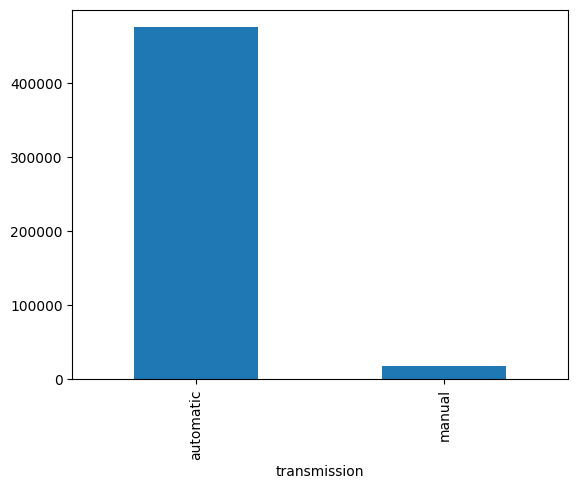

In [12]:
df['transmission'].value_counts().plot(kind='bar')

In [13]:
df_trans_test = df[['transmission', 'sellingprice', 'year', 'odometer']].copy()
df_trans_test['transmission'] = df_trans_test['transmission'].fillna('Unknown')
df_trans_test.groupby('transmission')[['sellingprice', 'year', 'odometer']] \
    .agg(['mean', 'median', 'count'])




sellingprice                          year                  \
                      mean   median   count         mean  median   count   
transmission                                                               
Unknown       14778.210535  13500.0   65172  2010.179648  2012.0   65172   
automatic     13528.445590  12000.0  475271  2010.089488  2012.0  475271   
manual        11197.679795   8600.0   17520  2008.124543  2009.0   17520   

                  odometer                   
                      mean   median   count  
transmission                                 
Unknown       65390.836602  45800.0   65172  
automatic     68419.217739  52748.0  475271  
manual        77426.810046  67927.5   17520

Comparison across automatic, manual, and missing transmission groups shows that vehicles with unknown transmission are not older or cheaper. In fact, they exhibit similar production years to automatic vehicles, lower mileage, and higher median prices than both automatic and manual groups. This indicates that missing transmission values do not proxy manual transmission, but instead reflect data source or reporting differences. Consequently, missing transmission is treated as a separate informative category.


In [14]:
df['transmission']=df['transmission'].fillna('Unknown')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 557963 entries, 0 to 558836
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               557963 non-null  int64  
 1   make               557963 non-null  object 
 2   model              557963 non-null  object 
 3   trim               557963 non-null  object 
 4   body               557963 non-null  object 
 5   transmission       557963 non-null  object 
 6   vin                557963 non-null  object 
 7   state              557963 non-null  object 
 8   condition          557963 non-null  float64
 9   odometer           557963 non-null  float64
 10  color              557963 non-null  object 
 11  interior           557963 non-null  object 
 12  seller             557963 non-null  object 
 13  mmr                557963 non-null  float64
 14  sellingprice       557963 non-null  float64
 15  saledate           557963 non-null  object 
 16  body_mi

In [16]:
df.drop(['body_missing', 'condition_missing', 'trim_missing', 'model_missing', 'make_missing'], axis=1, inplace=True)



In [17]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

All variables were assigned appropriate data types prior to modeling. Numerical features were retained as numeric types, categorical features as objects for downstream encoding, and date variables were converted to timezone-consistent datetime format to support feature engineering.


lets now check outliers for numerical columns

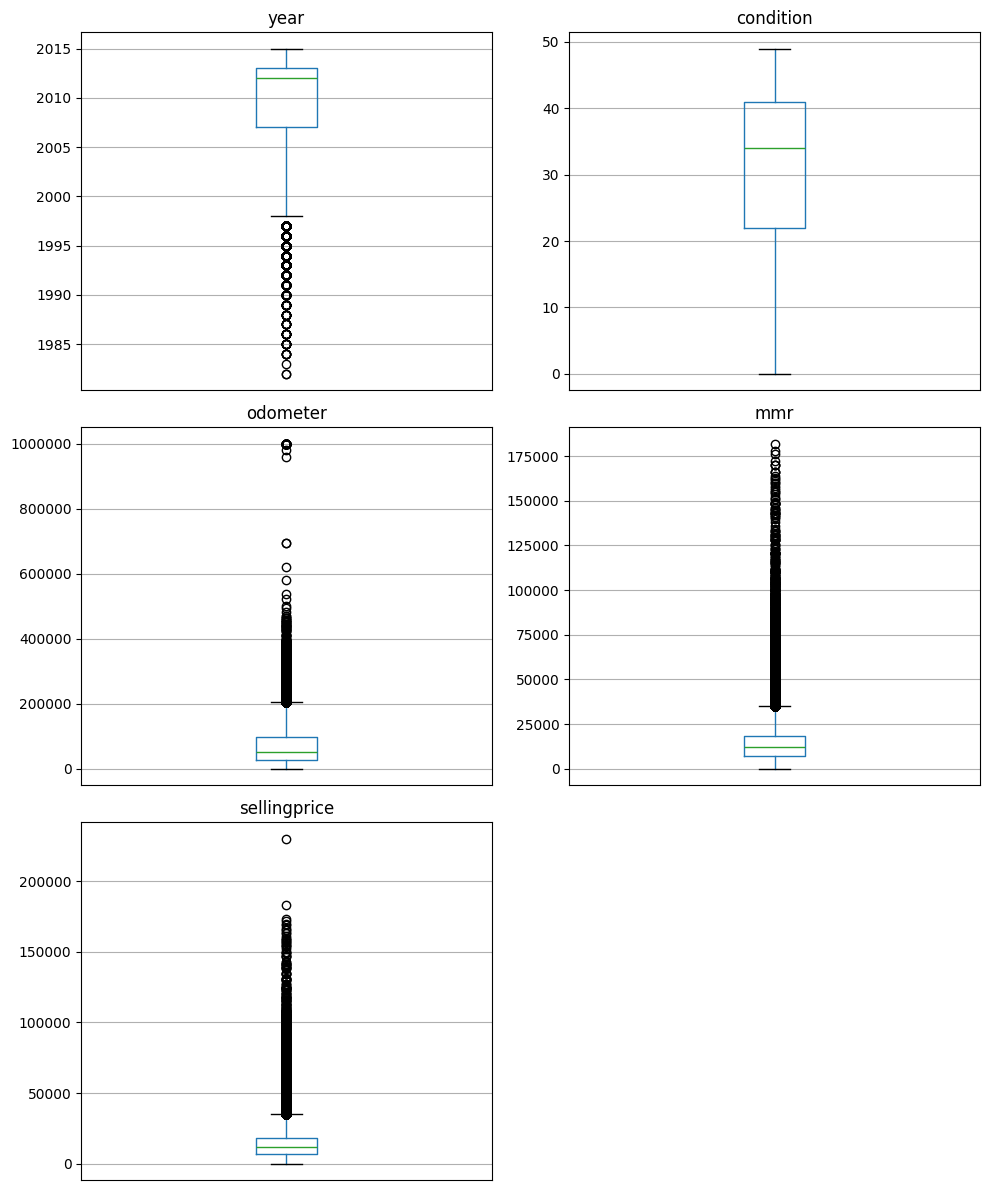

In [18]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    df.boxplot(column=col, ax=axes[i], showfliers=True)
    axes[i].set_title(col)
    axes[i].set_xticks([])
    axes[i].ticklabel_format(style='plain', axis='y')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()



#feature engenering idea-> age =current year- year #current year as per analysis is 2015
Analiza obserwacji odstających wykazała ich zróżnicowany charakter.
W przypadku zmiennej objaśnianej (sellingprice) obserwacje skrajne uznano za rzeczywiste przypadki rynkowe i nie zostały one usunięte.
Dla zmiennej odometer, charakteryzującej się silną prawostronną skośnością, zastosowano winsoryzację na poziomie 99 percentyla w celu ograniczenia wpływu ekstremalnych przebiegów.
Zmienne year oraz mmr pozostawiono bez ingerencji, uznając ich wartości skrajne za ekonomicznie uzasadnione.


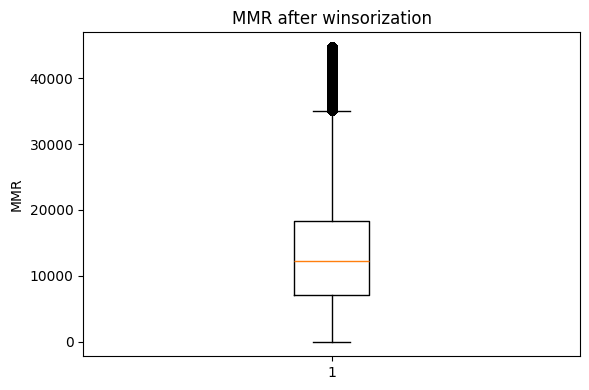

In [19]:

upper = df['mmr'].quantile(0.99)
df['mmr'] = df['mmr'].clip(upper=upper)

plt.figure(figsize=(6,4))
plt.boxplot(df['mmr'].values, vert=True, showfliers=True)
plt.title('MMR after winsorization')
plt.ylabel('MMR')
plt.tight_layout()
plt.show()


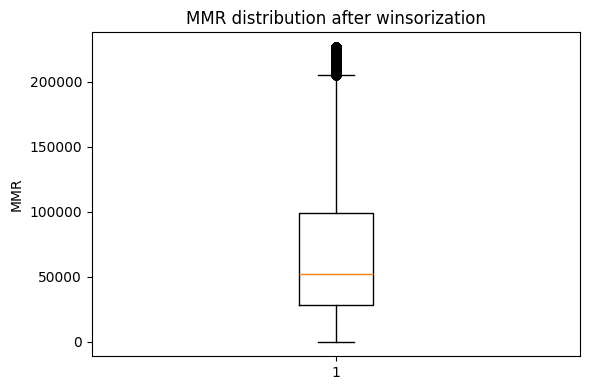

In [20]:
upper_odometer=df['odometer'].quantile(0.99)
df['odometer']=df['odometer'].clip(upper=upper_odometer)
plt.figure(figsize=(6, 4))
plt.boxplot(
    df['odometer'],
    vert=True,
    showfliers=True
)

plt.title('MMR distribution after winsorization')
plt.ylabel('MMR')
plt.tight_layout()
plt.show()


In [21]:
df.sort_values('sellingprice',ascending=True)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
293223,2014,Ford,E-Series Van,E-250,E-Series Van,automatic,1ftne2ew6eda13643,tx,41.0,31886.00,white,gray,u-haul,20800.0,1.0,Thu Feb 12 2015 03:00:00 GMT-0800 (PST)
48453,2003,Mercedes-Benz,E-Class,E500,Sedan,automatic,wdbuf70j73a269529,ga,21.0,1.00,black,black,peoples credit company inc,7325.0,1.0,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
348252,1995,Isuzu,Rodeo,LS,SUV,Unknown,4s2cm58v9s4375559,va,1.0,226659.28,red,gray,automotive remarketing inc,375.0,1.0,Wed Mar 04 2015 01:05:00 GMT-0800 (PST)
196184,2004,Pontiac,Montana,Base,Minivan,automatic,1gmdu03e74d147553,hi,2.0,106495.00,silver,gray,first hawaiian bank,1700.0,100.0,Wed Jan 28 2015 06:30:00 GMT-0800 (PST)
421787,2002,Dodge,Durango,SLT,SUV,automatic,1b4hr48n52f205682,pr,19.0,145161.00,silver,gray,pr auto loans llc,1275.0,100.0,Thu May 14 2015 03:00:00 GMT-0700 (PDT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125095,2012,Rolls-Royce,Ghost,Base,Sedan,automatic,sca664s58cux50727,fl,45.0,14316.00,black,beige,braman motorcars,44738.0,169500.0,Wed Jan 14 2015 01:40:00 GMT-0800 (PST)
545523,2013,Rolls-Royce,Ghost,Base,sedan,automatic,sca664s52dux52152,fl,42.0,7852.00,white,beige,flag/landrover southpointe,44738.0,171500.0,Wed Jun 17 2015 03:05:00 GMT-0700 (PDT)
446949,2015,Mercedes-Benz,S-Class,S65 AMG,Sedan,automatic,wddug7kb2fa102347,ca,41.0,5277.00,white,white,mercedes-benz usa,44738.0,173000.0,Thu May 21 2015 05:00:00 GMT-0700 (PDT)
548169,2011,Ferrari,458 Italia,Base,coupe,automatic,zff67nfa1b0178698,fl,46.0,12116.00,red,black,platinum motor cars,44738.0,183000.0,Wed Jun 17 2015 03:40:00 GMT-0700 (PDT)


In [22]:
(df['sellingprice'] < 1000).mean()

np.float64(0.028213340311095896)

In [23]:

df[df['sellingprice'] < 1000][['year', 'odometer', 'sellingprice']].describe()


,year,odometer,sellingprice
count,15742.000000,15742.000000,15742.000000
mean,2000.699085,158881.865941,586.939271
std,3.413200,52147.499998,211.016575
min,1985.000000,1.000000,1.000000
25%,1999.000000,130908.250000,400.000000
50%,2001.000000,162460.000000,600.000000
75%,2003.000000,197797.500000,800.000000
max,2014.000000,226659.280000,999.000000


Observations with selling prices below 1,000 and above 170,000 were excluded from the analysis, as these extreme values correspond to atypical market transactions and would introduce undue leverage, potentially biasing parameter estimates and degrading model performance.

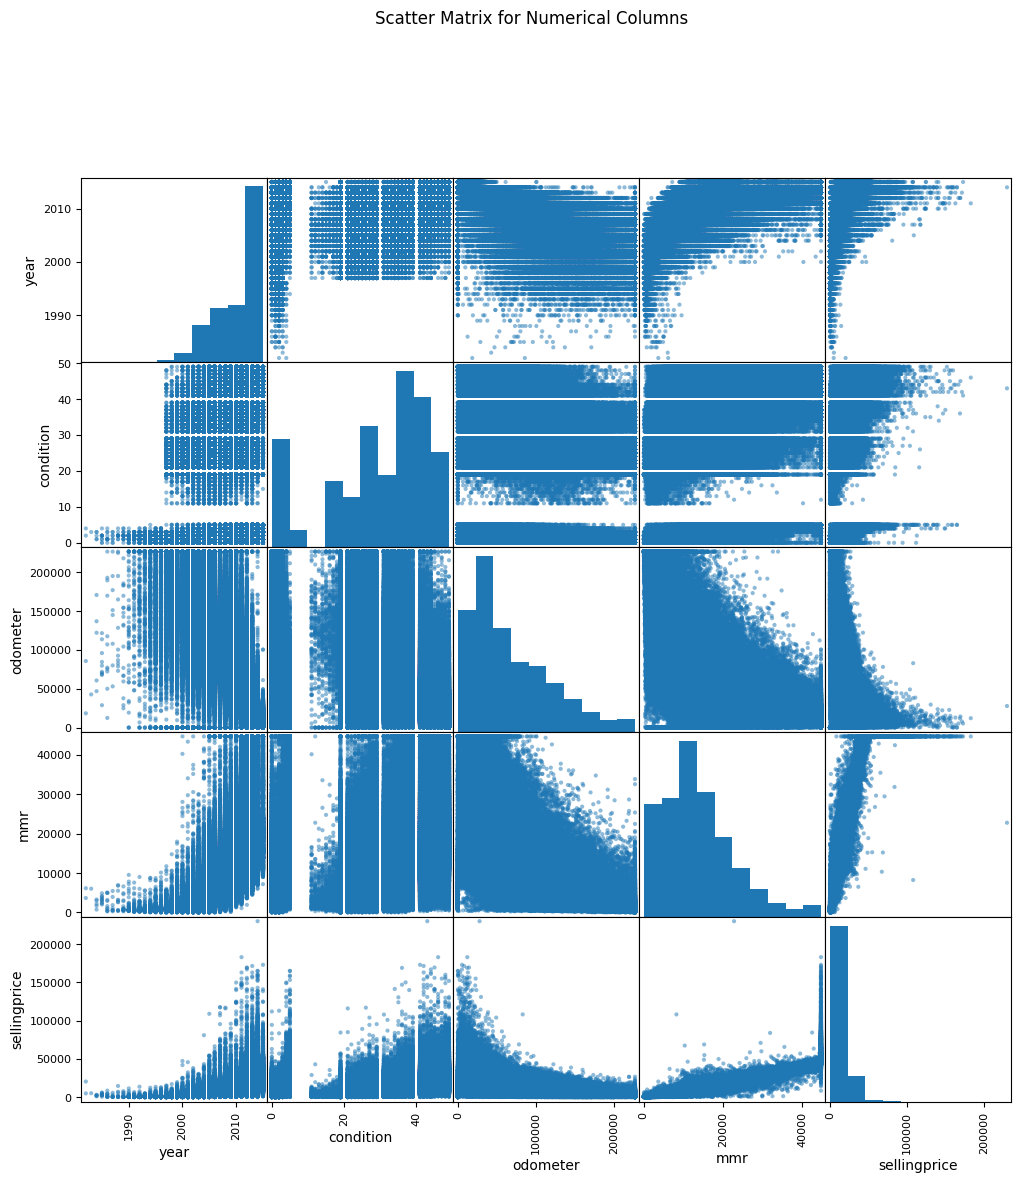

In [24]:
scatter_matrix(df[num_cols], alpha=0.5, figsize=(12, 12), diagonal='hist')
plt.suptitle('Scatter Matrix for Numerical Columns', y=1.02)
plt.show()

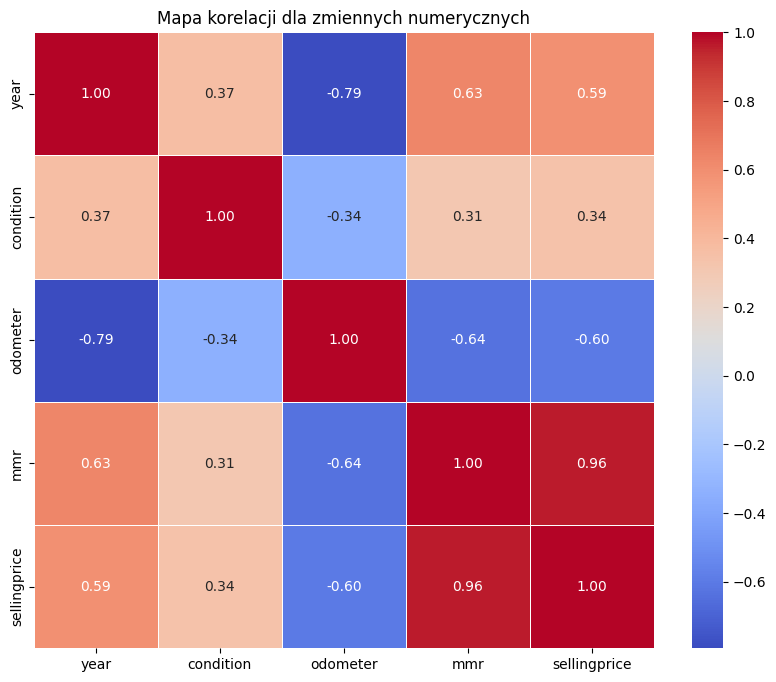

In [25]:
# Usuwanie kolumn tekstowych
df_num = df.select_dtypes(include=['float64', 'int64'])

# Obliczanie macierzy korelacji
corr = df_num.corr()

# Tworzenie mapy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa korelacji dla zmiennych numerycznych')
plt.show()


In [26]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

we can drop vin seller model i saledate  for sure, no value for model-> no value for prediction


In [27]:
df.drop(['saledate','vin','model','seller'],axis=1,inplace=True)

##feature enenering

In [28]:
df['car_age']=df['year'].max()-df['year']
df['miles_per_year']=df['odometer']/df['car_age'].clip(lower=1)
df.drop('year',axis=1,inplace=True)

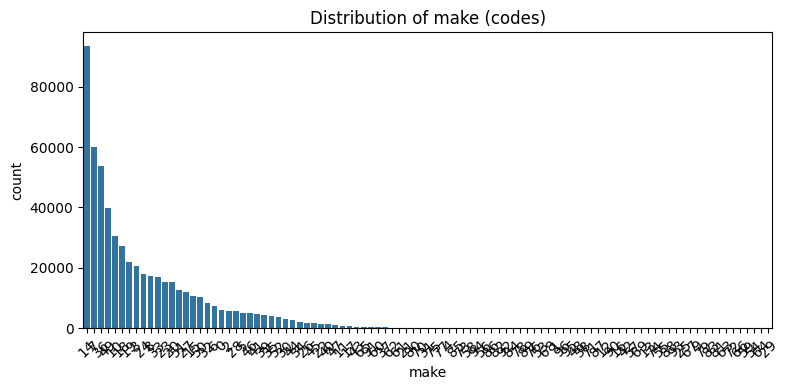

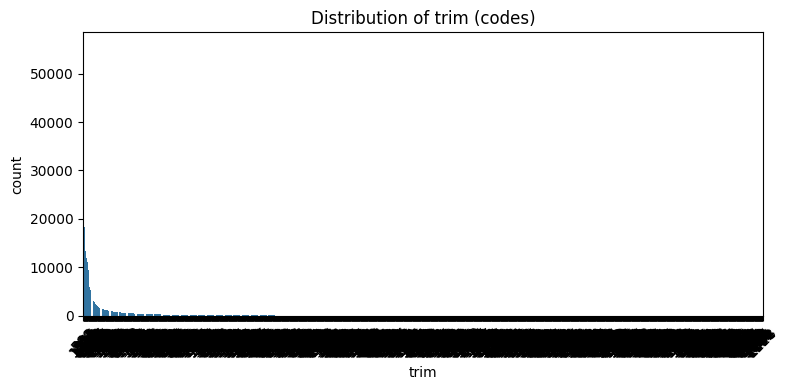

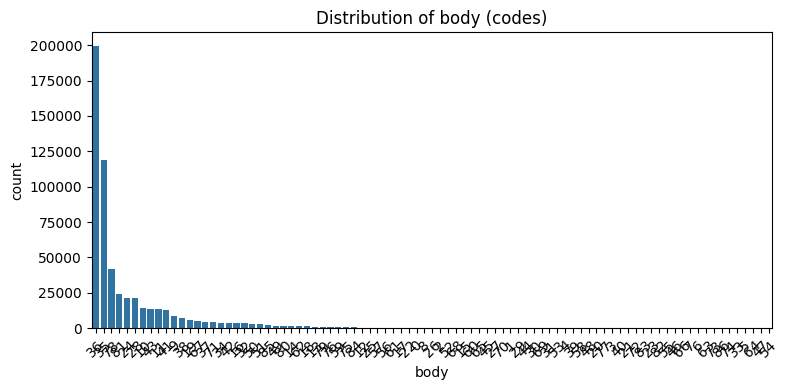

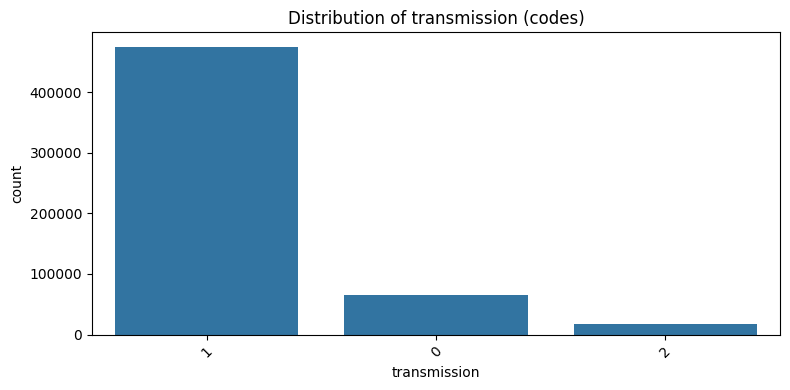

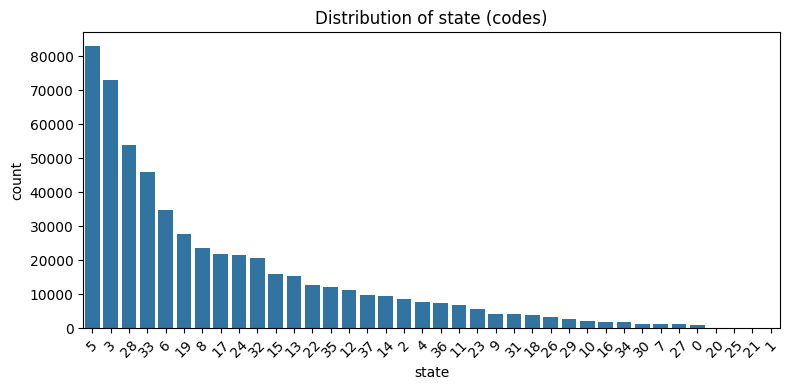

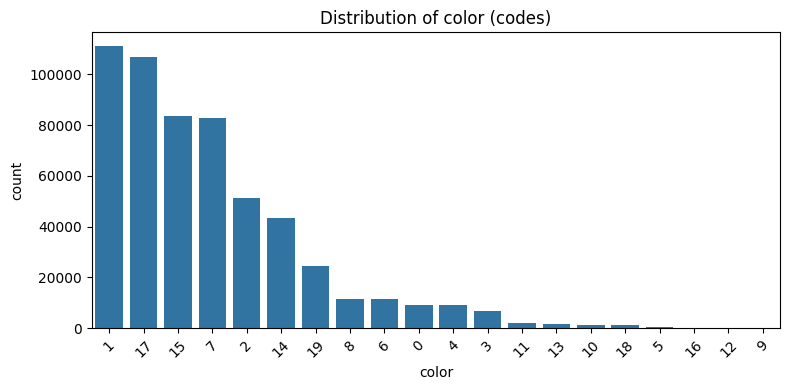

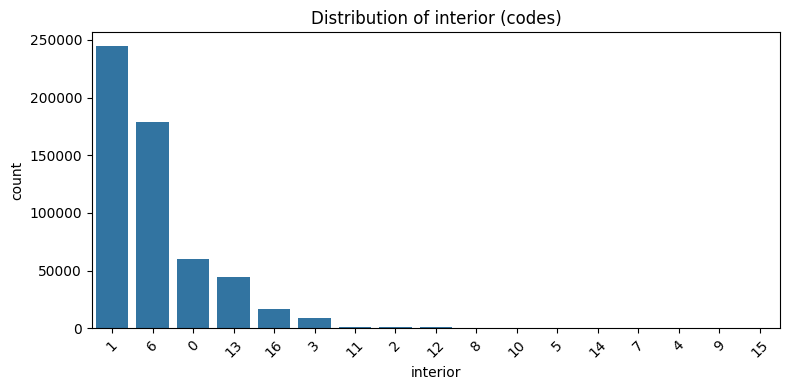

In [29]:
object_cols = df.select_dtypes(include=['object']).columns
object_cols_df = df.copy()

for col in object_cols:
    object_cols_df[col] = object_cols_df[col].astype('category').cat.codes
    
    plt.figure(figsize=(8,4))
    order = object_cols_df[col].value_counts().index
    sns.countplot(data=object_cols_df, x=col, order=order)
    plt.title(f'Distribution of {col} (codes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [30]:
df.drop(['trim'],axis=1,inplace=True)

In [31]:
cat_cols = [
    'make',
    'body',
    'state',
    'color',
    'interior',
    #'transmission' no need to transform
]


In [32]:
coverage = 0.85
summary = []
df_processed = df.copy()
for col in cat_cols:
    freq = df_processed[col].value_counts(normalize=True)
    cum = freq.cumsum()
    top_cats = cum[cum <= coverage].index

    # edge-case: gdyby top_cats było puste
    if len(top_cats) == 0:
        top_cats = freq.index[:1]
    df_processed[col]=df_processed[col].where(
        df_processed[col].isin(top_cats),
         other='Other')

    summary.append({
        'column': col,
        'top_n': len(top_cats),
        'coverage_reached': freq.loc[top_cats].sum(),           # faktyczny udział top_n
        'unique_before': df[col].nunique(),
        'unique_after': df_processed[col].nunique(),          # po dodaniu "Other"
        'share_other': (df_processed[col] == 'Other').mean()  # % wierszy w Other
    })

summary_df = pd.DataFrame(summary).sort_values('top_n', ascending=False)
summary_df


,column,top_n,coverage_reached,unique_before,unique_after,share_other
0,make,16,0.834290,97,17,0.165710
2,state,15,0.847477,38,16,0.152523
1,body,9,0.840108,87,10,0.159892
3,color,5,0.779545,20,6,0.220455
4,interior,2,0.757850,17,3,0.242150


Categorical variables were truncated using a cumulative frequency threshold of 85%, resulting in a compact and stable representation while retaining the majority of the data distribution. Rare categories were grouped into an Other class to reduce noise and improve model robustness.

In [33]:
for col in cat_cols:
    print(col, (df_processed[col] == 'Other').mean())


make 0.16570991266445984
body 0.15989232260920527
state 0.15252265831246875
color 0.22045547823063535
interior 0.24215046517421407


In [34]:
print(df_processed.head(5))

    make   body transmission state  condition  odometer  color interior  \
0    Kia    SUV    automatic    ca        5.0   16639.0  white    black   
1    Kia    SUV    automatic    ca        5.0    9393.0  white    Other   
2    BMW  Sedan    automatic    ca       45.0    1331.0   gray    black   
3  Other  Sedan    automatic    ca       41.0   14282.0  white    black   
4    BMW  Sedan    automatic    ca       43.0    2641.0   gray    black   

       mmr  sellingprice  car_age  miles_per_year  
0  20500.0       21500.0        0         16639.0  
1  20800.0       21500.0        0          9393.0  
2  31900.0       30000.0        1          1331.0  
3  27500.0       27750.0        0         14282.0  
4  44738.0       67000.0        1          2641.0  


In [35]:
df_processed.to_csv(r"C:\Users\User\Desktop\python projekty/used_cars_model_ready_ridge.csv", index=False)
df.to_csv(r"C:\Users\User\Desktop\python projekty/used_cars_model_ready_rf.csv", index=False)

## Limitations and next steps

The dataset covers only about six months, limiting the ability to capture long term trends.

Some variables are highly correlated, which may require regularization or non linear models.

This notebook focuses only on EDA and data preparation. Model training and evaluation will be done in a separate notebook.

## Key insights for modeling

This EDA focuses on understanding the data and preparing it for the modeling stage, which will be handled in a separate notebook.

The target variable sellingprice is right skewed and includes extreme values, so robustness to outliers will matter in modeling.

Some features, especially mmr, are strongly related to the target. This is useful for prediction but may cause multicollinearity in linear models.

Categorical variables were cleaned consistently and missing values were kept as informative categories when appropriate.

Outliers were handled selectively using winsorization to reduce their impact without removing large parts of the data.